# Příklad zpracování sktrukturovaných dat
https://keras.io/examples/structured_data/structured_data_classification_from_scratch/

Co se naučíme:
- Vyzkoušíme si predikci pravděpodobnosti pro reálná data.  
    - "S jakou pravděpodobnsotí má pacient onemocnění srdce?"
    - Pravděpodobnost je buď v intervalu 0-1 nebo v procentech. Pravděpodobnsot 1 odpovídá 100%.

In [70]:
%pip install pandas==2.0.3
%pip install ipympl
%pip install lightning

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [112]:
# Import potřebných knihoven
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget
from ipywidgets import widgets, interact
import ipympl
from tqdm import tqdm

import pandas as pd # knihovna pro práci s daty
import prettytable as pt # knihovna pro výpis tabulek
import matplotlib.pyplot as plt # knihovna pro vykreslování grafů
import numpy as np
import torch

print("Version of pandas: " + pd.__version__)
print("Version of prettytable: " + pt.__version__)

Version of pandas: 2.0.3
Version of prettytable: 3.11.0


# Co jsou strukrutovaná data?

#### Stáhneme si veřejně dostupný dataset onemocnění srdce:
Spracujeme data pomocí pandas.DataFrame - dokumentace zde: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

In [6]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)

# Jak jsou data uložena?
dataframe.head() # zobrazí prvních 5 řádků

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


# Co tato čísla znamenají?
- Každý vzorek dat (tj. pacient) obsahuje různé typy featur - věk, pohlaví, typ bolesti...
- Každá featura může nabývat různých hodnot. Kategorické hodnoty, např. typ bolesti (cp), jsou kódované předem zvoleným číslem kategorie. Např. typ bolesti 'typical angina' je v datasetu kódován číslem 2.
- Některé featury jsou přirozeně číselného charakteru - např. krevní tlak (trestbps).
- Kódování pro tento dataset lze dohledat v dokumentaci k datasetu. https://archive.ics.uci.edu/ml/datasets/heart+Disease


In [7]:
# Kódování kategorií známe z dokumentace k datasetu. Číselná hodnota odpovídá pořadí v seznamu.

# Feature "cp", neboli typ bolesti nabývá následujících 6 hodnot:
pain_types = ['unknown', 'typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic']

# Ostatní kategorické featury
sexes = ['Female', 'Male']
YesNo = ['No', 'Yes']
electrocardiographic_results = ['normal', 'ST-T wave abnormality', 'left ventricular hypertrophy']
slopes = ['unknown', 'upsloping', 'flat', 'downsloping']

# Metoda pro dekódované vytištění našich dat
def print_data(dataframe, patient_index):

    datarow = dataframe.iloc[patient_index]

    # poskládáme si tabulku
    table = pt.PrettyTable()
    table.field_names = ["Shortcut", "Description", "Value for patient number " + str(patient_index)  ]
    table.add_row(["age", "age in years", datarow[0]])
    table.add_row(["sex", "biological sex", sexes[datarow[1]]])
    table.add_row(["cp", "Chest pain type (0, 1, 2, 3, 4)", pain_types[datarow[2]]])
    table.add_row(["trestbps", "Resting blood pressure (in mm Hg on admission)", datarow[3]])
    table.add_row(["chol", "Cholesterol in mg/dl", datarow[4]])
    table.add_row(["fbs", "Fasting blood sugar in 120 mg/dl", YesNo[datarow[5]]])
    table.add_row(["restecg", "Resting electrocardiographic results", electrocardiographic_results[datarow[6]]])
    table.add_row(["thalach", "Maximum heart rate achieved", datarow[7]])
    table.add_row(["exang", "Exercise induced angina", YesNo[datarow[8]]])
    table.add_row(["oldpeak", "ST depression induced by exercise relative to rest", datarow[9]])
    table.add_row(["slope", "Peak exercise ST segment", slopes[datarow[10]]])
    table.add_row(["ca", "Number of major vessels (0-3) colored by fluoroscopy", datarow[11]])
    table.add_row(["thal", "Thal (3 = normal; 6 = fixed defect; 7 = reversible defect)", datarow[12]])
    table.add_row(["target", "Diagnosis of heart disease", datarow[13]])


    # vytištění tabulky
    print(table)

# vytištění příkladu dat - změníme parametr patient_index pro zobrazení jiného pacienta
for i in range(3):
    print_data(dataframe,patient_index=i)

+----------+------------------------------------------------------------+------------------------------+
| Shortcut |                        Description                         |  Value for patient number 0  |
+----------+------------------------------------------------------------+------------------------------+
|   age    |                        age in years                        |              63              |
|   sex    |                       biological sex                       |             Male             |
|    cp    |              Chest pain type (0, 1, 2, 3, 4)               |        typical angina        |
| trestbps |       Resting blood pressure (in mm Hg on admission)       |             145              |
|   chol   |                    Cholesterol in mg/dl                    |             233              |
|   fbs    |              Fasting blood sugar in 120 mg/dl              |             Yes              |
| restecg  |            Resting electrocardiographic re

# Výskyt nemoci v závislosti na věku
- Lze predikovat pravděpodobnost výskytu nemoci jen v závislosti na věku?
- Podívejme se na data:

In [43]:
# Vykreslíme si graf závislosti onemocnění na věku, kde na ose x bude věk a na ose y pravděpodobnost výskytu srdečního onemocnění
# fig = plt.figure()
# plt.scatter(dataframe['age'], dataframe['target'])
# plt.xlabel("Age")
# plt.ylabel("Target")
# plt.show()


def linear_ml(x, w=1, b=2):
    y = w*x + b
    return y

def dataset_loss_linear(dataset, feature="age", w=1, b=2, normalize=False):
    '''
    Funkce pro výpočet hodnoty chybové funkce MSE pro lineární regresi na celém datasetu.
    '''
    loss_value = 0
    for row in dataset.iloc:
        loss_value += (linear_ml(row[feature], w=w, b=b) - row['target']) ** 2
    return loss_value / len(dataset)


# Zobrazovač lineární funkce s daty
def display_linear_with_data2(x_min, x_max, dataset, feature, loss_value, w=1, b=0):
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlim(min(dataset[feature])-1, max(dataset[feature])+1)
    plt.ylim(min(dataset['target'])-1, max(dataset['target'])+1)

    plt.scatter(dataset[feature], dataset['target'], color='red')

    for row in dataset.iloc:
        x_val = row[feature]
        y_val = linear_ml(x_val, w=w, b=b)
        plt.plot([x_val, x_val], [y_val, row['target']], color='red', linestyle='dotted')
        plt.plot(x_val, row['target'], marker='o', markersize=5, color='blue')
    plt.grid(True)

    x = np.linspace(x_min, x_max, 100)
    plt.plot(x, linear_ml(x, w=w, b=b))
    plt.title(f'Lineární funkce - pravděpodobnost onemocnění srdce\n w={w} \n b={b}\n loss={loss_value:.5f}')

    plt.xlabel(feature)
    plt.ylabel('Pravděpodobnost nemoci')

    plt.gcf().set_size_inches(10, 6)
    plt.show()

# Grafické slidery pro nastavení vah w a b
output_slider_w = widgets.FloatSlider(min=-0.05, max=0.05, step=0.001, value=00.009844091720879078)
output_slider_b = widgets.FloatSlider(min=-1, max=1, step=0.001, value=-0.26350080966949463)

# Můžete zkusit vybrat jinou feature z datasetu
feature = "age"

def set_params(w, b):
    loss_value = dataset_loss_linear(dataset=dataframe, feature=feature,w=w, b=b)
    display_linear_with_data2(-100, 500, dataset=dataframe, feature=feature,loss_value=loss_value, w=w, b=b)


interact(set_params, w=output_slider_w, b=output_slider_b)


interactive(children=(FloatSlider(value=0.009844091720879078, description='w', max=0.05, min=-0.05, step=0.001…

<function __main__.set_params(w, b)>

# Lze tyto data použít k predikci?
- Nejlepší lineární model pro predikci v závislosti na věku má průměrnou chybu predikce 44%.
- Porovnejme predikci s metodou náhodného hádání...

In [53]:
# Jaká je průměrná chyba predikce modelu na celém datasetu?

def mean_dataset_error(dataset, feature="age", w=1, b=2, normalize=False):
    '''
    Funkce pro výpočet hodnoty chybové funkce L1 pro lineární regresi na celém datasetu.
    '''
    error_value = 0
    largest_error = 0
    for row in dataset.iloc:
        row_error = abs(linear_ml(row[feature], w=w, b=b) - row['target'])
        if row_error > largest_error:
            largest_error = row_error
        error_value += row_error
    return error_value / len(dataset), largest_error

def random_prediction_error(dataset, normalize=False):
    '''
    Funkce pro výpočet při náhodném uhodnutí.
    '''
    error_value = 0
    largest_error = 0
    for row in dataset.iloc:
        guess = np.random.randint(0, 2)
        row_error = abs(guess - row['target'])
        if row_error > largest_error:
            largest_error = row_error
        error_value += row_error
    return error_value / len(dataset), largest_error

dataset_error, largest_error = mean_dataset_error(dataset=dataframe, feature=feature, w=output_slider_w.value, b=output_slider_b.value)
print(f"Model prediction error: {dataset_error}, model is {dataset_error*100} % wrong on average. Largest error is {largest_error*100} %")

random_error, largest_random_error = random_prediction_error(dataset=dataframe)
print(f"Random guess error: {random_error}, model is {random_error*100} % wrong on average. Largest error is {largest_random_error*100} %")

Model prediction error: 0.38207806849686227, model is 38.20780684968623 % wrong on average. Largest error is 88.94253242760897 %
Random guess error: 0.5115511551155115, model is 51.15511551155115 % wrong on average. Largest error is 100 %


# Potřebujeme další data...
- Zkusíme si prohlédnout rozložení dat v závislosti na dvou proměnných (featurách)


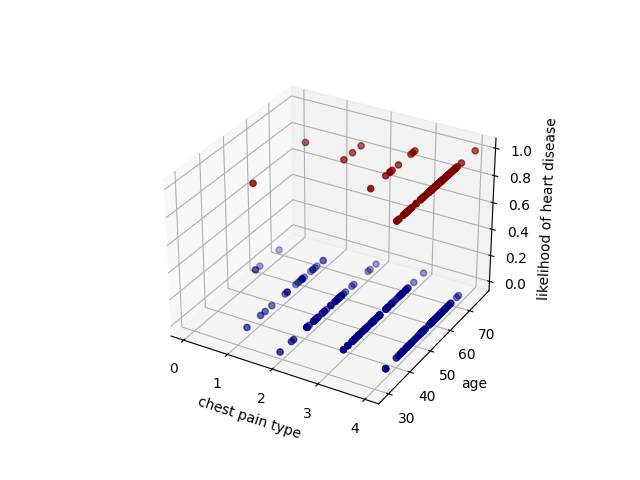

In [69]:
# Pridáme další proměnnou a zobrazíme si 3d graf
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(dataframe['cp'], dataframe['age'], dataframe['target'], cmap='jet', c=dataframe['target'])

# osy x a y jsou proměnné, které máme k dispozici
ax.set_xlabel('chest pain type')
ax.set_ylabel('age')

# osa z je proměnná, kterou chceme predikovat
ax.set_zlabel('likelihood of heart disease')

plt.show()

# Zkusíme natrénovat model na dvou featurách
- Použijeme tentokrát knihovnu pytorch lightning https://lightning.ai/docs/pytorch/stable/
- Musíme definovat model jako LightningModule
    - Vytvoříme si třídu LModel.
    - Třída je objekt, který má vlastní data (třeba self.model) a vlastní metody (třeba forward())
- AgePainDataset bude další třída. Obsahuje:
    - náš dataset,
    - metody pro zakódování a normalizaci dat,
    - metody pro vybírání vzorků z datasetu. (Vzorek je typu Tensor.)


In [110]:
# Tady si nachystáme požadované třídy

import lightning as L

# Vytvoříme model, tentokrát jako lightening module
class LModel(L.LightningModule):
    def __init__(self, inputs, hidden_units):
        super().__init__()

        # Samotný model je klasický sekvenční torch model
        self.model = torch.nn.Sequential(
            torch.nn.Linear(inputs, hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_units, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        '''
        Funkce pro předání dat do modelu. Zde pouhé zavolání model, jak už jsme viděli dříve...
        '''
        return self.model(x)

    def configure_optimizers(self):
        '''
        Nastavení trénovacího algoritmu je tentokrát zde v modulu.
        '''
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        '''
        Funkce pro jeden trénovací krok.
        '''
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.binary_cross_entropy(y_hat, y)
        self.log("[TRAIN LOSS]", loss, prog_bar=True)
        error = torch.mean(torch.abs(y_hat - y))
        self.log("[TRAIN ERROR]", error, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        '''
        Funkce pro jeden validační krok.
        '''
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.binary_cross_entropy(y_hat, y)
        error = torch.mean(torch.abs(y_hat - y))
        self.log("[VAL LOSS]", loss, prog_bar=True)
        self.log("[VAL ERROR]", error, prog_bar=True)
        return loss

# Torch Dataset pro naše dvě featury
class AgePainDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

        self.age_std = self.dataframe['age'].std()
        self.age_mean = self.dataframe['age'].mean()

    def __len__(self):
        return len(self.dataframe)

    def normalize_age(self, age):
        '''
        Číselnou featuru opět znormalizujeme aby se pohybovala kolem 0.
        '''
        return torch.tensor((age - self.age_mean) / self.age_std).unsqueeze(0).to(torch.float32)

    def one_hot_encode_cp(self, cp):
        '''
        Kategorickou featuru převedeme na one hot encoding.

        cp = 0 bude reprezentováno jako [1, 0, 0, 0, 0]
        cp = 1 bude reprezentováno jako [0, 1, 0, 0, 0]
        cp = 2 bude reprezentováno jako [0, 0, 1, 0, 0]
        ...
        '''
        one_hot = [0]*pain_types.__len__()
        one_hot[cp] = 1
        return torch.tensor(one_hot).to(torch.float32)

    def __getitem__(self, idx):
        '''
        Funkce pro získání jednoho vzorku z datasetu.
        '''
        age = self.normalize_age(self.dataframe.iloc[idx]['age'])
        cp = self.dataframe.iloc[idx]['cp']
        cp = self.one_hot_encode_cp(cp)
        target = self.dataframe.iloc[idx]['target']
        return torch.cat((age, cp)), torch.tensor(target).unsqueeze(0).to(torch.float32)






# Trénovací smyčku teď zajistí "Trenér"
- Předtím jsme museli napsat smyčku sami, teď využijeme Trainer třídu z knihovny lightning

In [132]:

# Z datasetu budeme vybírat podmnožiny dat s počtem vzorků batch_size
batch_size = 16

# 1 epocha = model "viděl" všechna data v datasetu. Počet epoch znamená kolikrát model "viděl" celý dataset.
epochs = 60

# Vytvoření modelu z naší třídy LModel
age_pain_model = LModel(inputs=6, hidden_units=32)

# Vytvoření "trenéra" z knihovny lightning
age_pain_trainer = L.Trainer(max_epochs=epochs)

# Data rozdělíme na dvě množiny
# Trénovací dataset - tyto data model uvidí během trénování
age_pain_dataset_train = AgePainDataset(dataframe.sample(frac=0.8, random_state=0))

# Validační dataset - tyto data model během trénování neuvidí. Změříme na nich, jak dobře se modelu daří predikovat pro vzorky, které nikdy neviděl.
age_pain_dataset_val = AgePainDataset(dataframe.drop(age_pain_dataset_train.dataframe.index))

# Pomocné třídy na opakované vytahování batchů dat
train_dataloader = torch.utils.data.DataLoader(age_pain_dataset_train, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(age_pain_dataset_val, batch_size=batch_size)

# Zde se teď skrývá trénovací smyčka
age_pain_trainer.fit(model=age_pain_model,
                    train_dataloaders=train_dataloader)

age_pain_trainer.validate(model=age_pain_model, dataloaders=val_dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 257    | train
---------------------------------------------
257       Trainable params
0         Non-trainable params
257       Total params
0.001     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params |

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=60` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        [VAL ERROR]        │    0.30754953622817993    │
│        [VAL LOSS]         │    0.4095684289932251     │
└───────────────────────────┴───────────────────────────┘

[{'[VAL LOSS]': 0.4095684289932251, '[VAL ERROR]': 0.30754953622817993}]

# Vizualizujeme si natrénovaný model
- Model odpovídá nějaké funkci - vykreslíme si ji


100%|██████████| 110/110 [00:00<00:00, 745.44it/s]


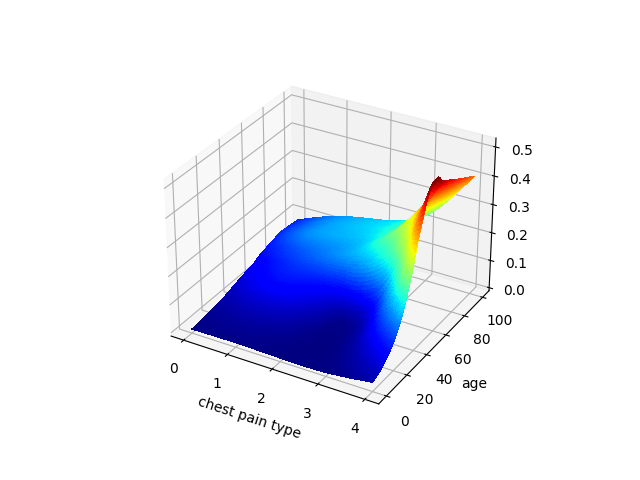

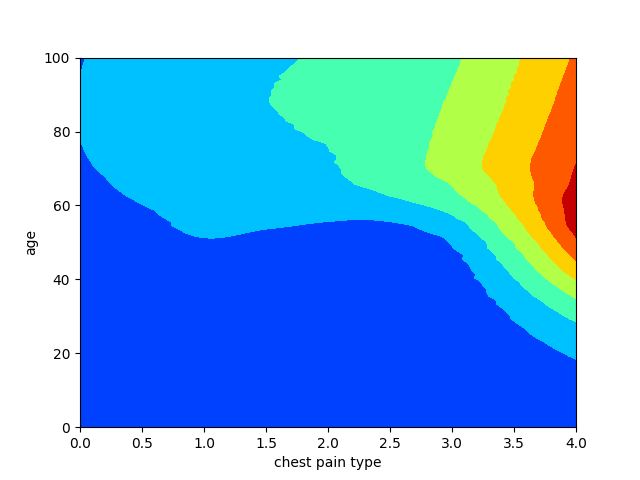

In [133]:
# Nachystáme si rozsah možných hodnot pro věk a cp
grid_age = np.arange(0, 110, 1)
grid_cp = np.arange(0, 5, 1)

# pustíme předikce pro všechny kombinace věků a cp a sledujeme průběh predikce pomocí tqdm
possible_ages = []
possible_cps = []
predictions = []

for age in tqdm(grid_age):
    for cp in grid_cp:
        possible_ages.append(age)
        possible_cps.append(cp)
        input_age = age_pain_dataset_train.normalize_age(age)
        input_cp = age_pain_dataset_train.one_hot_encode_cp(cp)
        input_data = torch.cat((input_age, input_cp))
        predictions.append(age_pain_model(input_data).item())

# Vykreslíme si predikce
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

from scipy.interpolate import griddata
# připravíme si mřížku bodů pro vykreslení
grid_x, grid_y = np.mgrid[0:4:100j, 0:100:100j]
grid_z = griddata((possible_cps, possible_ages), predictions, (grid_x, grid_y), method='cubic', fill_value=0)

ax.plot_surface(grid_x, grid_y, grid_z, cmap='jet',rstride=1, cstride=1,
                       linewidth=0, antialiased=False, shade=False)
ax.set_xlabel('chest pain type')
ax.set_ylabel('age')
plt.show()

fig = plt.figure()
ax2d = fig.add_subplot()
ax2d.contourf(grid_x, grid_y, grid_z, cmap='jet')
ax2d.set_xlabel('chest pain type')
ax2d.set_ylabel('age')
plt.show()